In [ ]:
# Model-Based RL - Using a model-based random shooting algorithm to solve HalfCheetah

# Code was used from: https://github.com/ZhengXinyue/Model-Predictive-Control/blob/master/Learning_MPC/Learning_MPC_Pendulum.py

### SANITY TEST ##############################################################

# ENVIRONMENT SUMMARY: -> Reacher-v2
# -> Continuous action space

# Observation -> 11 items
#    cos(theta) (first joint)        
#    cos(theta) (second joint)        
#    sin(theta) (first joint)        
#    sin(theta) (second joint)        
#    qpos (the x coordinate of the target )        
#    qpos (the y coordinate of the target )        
#    qvel (the velocity of the fingertip in the x direction )        
#    qvel (the velocity of the fingertip in the y direction )        
#    the x-axis component of the vector from the target to the fingertip        
#    the y-axis component of the vector from the target to the fingertip        
#    the z-axis component of the vector from the target to the fingertip    

# Action -> 2 items
# range from -1 to 1
# most likely correspond to torque of two joints

# Reward -> 1 item

### MAIN #######################################################################

# ENVIRONMENT SUMMARY: -> Cheetah-v2
# -> Continuous action space

# Observation -> 17 items

# Action -> 6 items

# Reward -> 1 item

#################################################################################

import os
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import pickle

# TO DO ##########################################################################

# adjust parameters similar to that of HW


# NOTES ##########################################################################

# the principle is that: more rollouts and longer horizon will make better performance.


##################################################################################

# Neural Network Design
def OurModel(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input    
    
    X = Dense(250, activation='relu')(X)
    X = Dense(250, activation='relu')(X)
    X = Dense(action_space)(X)
    
    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer=Adam(lr=0.001), loss='mse')

    return model

# Action Agent
class Agent:
    def __init__(self, env_name):
        
        # environmental variables 
        self.env_name = env_name       
        self.env = gym.make(env_name)
        # self.env.seed(0)  
        self.action_size = self.env.action_space.shape[0] 
        self.state_size = self.env.observation_space.shape[0]
        
        # takes action and previous state as input
        self.input_size = self.action_size + self.state_size
        self.output_size = self.state_size
        self.render = True
        
        # global variables
        self.rollout = 15
        self.horizon = 10   
        
        # training
        self.episodes = 500 
        self.batch_size = 512              
        
        # initialise memory
        self.replay_length = 100_000
        self.memory = deque(maxlen=self.replay_length)
        self.memory_mean = 0
        self.memory_std = 1
        self.memory_full = False
        
        # model
        self.system_model = OurModel(self.input_size, self.output_size)
        
        #analysis
        self.saved_rewards = []
    
    # normalise the input
    def normalise(self, input_val, mean, std):        
        out = input_val
        out -= mean
        out /= std
        
        return  out
        
    # unormalise the input
    def unnormalise(self, input_val, mean, std):
        out = input_val
        out *= std
        out += mean        
        
        return  out        
    
    # decide action from state
    def act(self, state): 
        
        best_action = None
        max_trajectory_value = -float('inf')
        
        for trajectory in range(self.rollout):
            trajectory_value = 0
            
            for h in range(self.horizon):
                
                # select a random action
                action = np.array([random.uniform(-1, 1), random.uniform(-1, 1)], dtype=np.float32) 
                if h == 0:
                    first_action = action                     
                                
                # get the combined state           
                combined_state = np.expand_dims(np.concatenate((state, action)), axis=0) 
                norm_state = self.normalise(combined_state, np.mean(combined_state), np.std(combined_state))
                
                # predict the next state     
                norm_diff = (self.system_model(combined_state).numpy()).reshape(self.output_size,)
                next_state = state + self.unnormalise(norm_diff, self.memory_mean, self.memory_std)
                
                # compute the reward                
                vec = next_state[8:]
                reward_dist = - np.linalg.norm(vec)
                reward_ctrl = - np.square(action).sum()
                costs = reward_dist + reward_ctrl
                
                # update trajectory
                trajectory_value += -costs
                state = next_state
                
            # check if this trajectory's value is higher.
            if trajectory_value > max_trajectory_value:
                max_trajectory_value = trajectory_value
                best_action = first_action
                
        return best_action
    
    # unpack data from memory 
    def unpack(self):
        
        # sample a minibatch        
        minibatch = random.sample(self.memory, self.batch_size)
        
        # initialise the data  
        state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        action = np.zeros((self.batch_size, self.action_size), dtype=np.float32)
        reward = np.zeros(self.batch_size, dtype=np.float32)        
        next_state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        done = np.zeros(self.batch_size, dtype=np.uint8)
        
        # unpack the data
        for i in range(len(minibatch)):
            state[i], action[i], reward[i], next_state[i], done[i] = minibatch[i]
        
        return state, action, reward, next_state, done
    
    # train the dynamics model
    def train(self):
                                        
        # access data from replay        
        state, action, _, next_state, _ = self.unpack()
        
        # normalise the difference
        diff = next_state - state
        self.memory_mean = np.mean(diff)
        self.memory_std = np.std(diff)
        norm_diff = self.normalise(diff, self.memory_mean, self.memory_std)
        
        # combine action and state 
        combined_state = np.concatenate((state, action), axis=1)    
        norm_state = self.normalise(combined_state, np.mean(combined_state), np.std(combined_state))
        
        # Train the Neural Network with batches
        self.system_model.fit(norm_state, norm_diff, batch_size=self.batch_size, verbose=0)
    
    # reset the state
    def reset(self):  
        return self.env.reset()        
    
    # load the model weights
    def load(self, name):
        self.systme_model.load_weights(name) 
    
    # save the model weights
    def save(self, name):
        self.system_model.save_weights(name)  
    
    # update the state and reward
    def step(self, action):
        next_state, reward, done, info  = self.env.step(action)        
        return next_state, reward, done, info       
    
    # run the agent    
    def run(self):
        
        for e in range(1, self.episodes + 1):
            
            print('Starting Episode: ', e)
            state = self.reset()
            done = False
            episode_reward = 0
            frame = 0  
        
            while not done:
                
                # render the environment                
                if self.render:
                    self.env.render()                  
                
                # train the model
                self.train()
                
                # act according to the agent
                action = self.act(state) 
                next_state, reward, done, _ = self.step(action)
                
                # update the replay
                self.memory.append((state, action, reward, next_state, done))                
                
                episode_reward += reward
                frame += 1
                state = next_state

                if done: 
                    
                    print('Episode {} Score: {}'.format(e, episode_reward))
                    self.saved_rewards.append(episode_reward)
                    
                    if e % 10 == 0:   
                        
                        # save the replay                          
                        with open("./Replays/replay1.txt", "wb") as file:
                            pickle.dump(self.memory, file)                            
                        
                        # save results
                        with open("./Results/rewards-ep-" + str(e) + ".txt", "wb") as file:
                            pickle.dump(self.saved_rewards, file) 

                        # save model
                        self.save('./Models/MB_Model.h5')
                
                
        self.env.close()
        

# load the replay memory
with open("./Replays/replay1.txt", "rb") as file:
    replay_save = pickle.load(file)          

if __name__ == "__main__":
    env_name = 'Reacher-v2'
    agent = Agent(env_name)
    agent.memory = replay_save
    agent.run()

-44.015584750213286


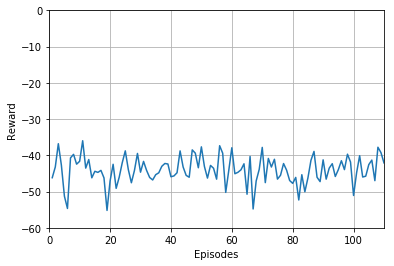

In [11]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt

with open("./Results/rewards-ep-110.txt", "rb") as file:
    a = pickle.load(file)    
    
print(np.mean(a))
    
x1 = np.array(range(1,111))
y1 = a

plt.plot(x1,y1)
plt.xlim(0, 110)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.ylim(-60, 0)
plt.grid(alpha=1.0)
# plt.savefig('./Images/Pon.png')

plt.show()
    
    
    
    